# Info

[cuda learning](https://nbviewer.org/github/apowers313/roc/blob/master/experiments/2024.07.23-10.38.05-cupy-learning/2024.07.23-10.38.05-cupy-learning.ipynb)

In [1]:
!date
print("=========")
!uname -a
print("=========")
import os
os.environ["PATH"] += os.pathsep + "/usr/local/cuda/bin"
!nvcc --version
print("=========")
!nvidia-smi
print("=========")
import cupy as cp
print("CuPy version", cp.__version__)
print("=========")
import numpy as np
print("NumPy version", np.__version__)

Thu Jul 25 07:39:45 PDT 2024
Linux 39f11d97b672 5.15.0-116-generic #126-Ubuntu SMP Mon Jul 1 10:14:24 UTC 2024 x86_64 x86_64 x86_64 GNU/Linux
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Mon_Oct_24_19:12:58_PDT_2022
Cuda compilation tools, release 12.0, V12.0.76
Build cuda_12.0.r12.0/compiler.31968024_0
Thu Jul 25 07:39:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+============

# Examples

In [2]:
# https://docs.cupy.dev/en/stable/reference/generated/cupyx.profiler.benchmark.html
import cupy as cp
from cupyx.profiler import benchmark

def f(a, b):
    return 3 * cp.sin(-a) * b

a = 0.5 - cp.random.random((100,))
b = cp.random.random((100,))
print(benchmark(f, (a, b), n_repeat=1000))

f                   :    CPU:    78.379 us   +/-  1.092 (min:    77.597 / max:    91.655) us     GPU-0:    83.603 us   +/-  1.244 (min:    81.920 / max:    97.632) us


In [3]:
# https://docs.cupy.dev/en/stable/user_guide/performance.html
import cupy as cp
from cupyx.profiler import benchmark

def my_func(a):
    return cp.sqrt(cp.sum(a**2, axis=-1))

a = cp.random.random((256, 1024))
print(benchmark(my_func, (a,), n_repeat=10000))  

my_func             :    CPU:    96.201 us   +/-  8.203 (min:    94.403 / max:   800.692) us     GPU-0:   269.350 us   +/- 43.769 (min:   256.320 / max:   818.112) us


# Profiling

## Setup

In [4]:
import numpy as np
import cupy as cp
from cupyx.profiler import benchmark

# https://github.com/cupy/cupy-benchmark/blob/master/benchmarks/numpy/bench_linalg.py
a = np.arange(60000000.0).reshape(1500, 40000)
b = np.arange(240000000.0).reshape(40000, 6000)
c = np.arange(6000)
d = np.arange(40000)

## NumPy

In [5]:
# https://github.com/cupy/cupy-benchmark/blob/master/benchmarks/numpy/bench_linalg.py
a = np.arange(60000000.0).reshape(1500, 40000)
b = np.arange(240000000.0).reshape(40000, 6000)
c = np.arange(6000)
d = np.arange(40000)
e = np.random.rand(1024,1024).astype("f")
f = np.random.rand(80,25).astype("f")

def np_dot(a, b):
    # np.dot(d, np.dot(b, c))
    # np.dot(a,b)
    # np.einsum('i,ij,j', d, b, c)
    # np.einsum('ij,jk', a, b)
    # np.matmul(a, b)
    # cp.max(e)
    cp.max(f)

%timeit np_dot(a, b)

6.37 μs ± 17.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## CuPy

In [6]:
# https://github.com/cupy/cupy-benchmark/blob/master/benchmarks/numpy/bench_linalg.py
a = cp.arange(60000000.0).reshape(1500, 40000)
b = cp.arange(240000000.0).reshape(40000, 6000)
c = cp.arange(6000)
d = cp.arange(40000)
e = cp.random.rand(1024,1024).astype("f")
f = cp.random.rand(80,25).astype("f")

def cp_dot(a, b):
    # https://github.com/cupy/cupy-benchmark/tree/master?tab=readme-ov-file#numpy-benchmark
    # the following was stolen from the @sync decorator used in CuPy's emulation
    # of NumPy benchmarks
    # https://github.com/cupy/cupy-benchmark/blob/master/benchmarks/utils/helper.py
    event = cp.cuda.stream.Event()
    event.record()
    event.synchronize()
    # cp.dot(d, cp.dot(b, c))
    # cp.dot(a, b)
    # cp.einsum('i,ij,j', d, b, c)
    # cp.einsum('ij,jk', a, b)
    # cp.matmul(a, b)
    # cp.max(e)
    cp.max(f)

    event = cp.cuda.stream.Event()
    event.record()
    event.synchronize()

%timeit cp_dot(a, b)
# print(benchmark(cp_dot, (a,b), n_repeat=10))  

49.1 μs ± 68.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Results

- `cp.dot(a, b)`
    - NumPy: 1.98 s ± 47.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    - CuPy:  2.97 s ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- `cp.dot(d, cp.dot(b, c))`
    - NumPy: 105 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
    - CuPy:  7.42 ms ± 2.45 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
- `cp.einsum('i,ij,j', d, b, c)`
    - NumPy: 574 ms ± 185 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)
    - CuPy:  118 ms ± 13.7 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
- `xp.einsum('ij,jk', a, b)`
    - NumPy: <<30+ minutes>>
    - CuPy:  3.1 s ± 8.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- `np.matmul(a, b)`
    - NumPy: 1.54 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    - CuPy:  2.98 s ± 9.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- `np.max(e)`
    - NumPy: 180 μs ± 141 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
    - CuPy:  61.1 μs ± 557 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
- `np.max(f)`
    - NumPy: 6.39 μs ± 20.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
    - CuPy:  49.1 μs ± 40 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

# Profile Curve Comparison

In [7]:
x = 2
def myfn():
    global x
    x = x + 1

ret = %timeit -o myfn()
# ret is TimeitResult
# https://github.com/ipython/ipython/blob/4581d8b93c42014c0c232ac5de169dad053ea809/IPython/core/magics/execution.py#L65
print("ret", ret)
print("ret type", type(ret))
print("best", ret.best)
print("all_runs", ret.all_runs)

231 ns ± 0.424 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
ret 231 ns ± 0.424 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
ret type <class 'IPython.core.magics.execution.TimeitResult'>
best 2.3030300399841508e-07
all_runs [0.23072249699907843, 0.23085065199848032, 0.2303078960030689, 0.23032910100300796, 0.23030300399841508, 0.23153323300357442, 0.23101275399676524]


In [8]:
from timeit import timeit

ret = timeit(stmt="myfn()", globals=globals(), number=50000)
print("ret", ret)

ret 0.012257507994945627


## Plotter Definition

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from timeit import timeit

import numpy as np
import cupy as cp

def setup(xp, sz):
    f1 = sz
    f2 = sz*3
    f3 = sz*4

    global a, b, c, d, e, f
    a = xp.arange(f1*f2).reshape(f1, f2)
    b = xp.arange(f2*f3).reshape(f2, f3)
    c = xp.arange(f3)
    d = xp.arange(f2)
    e = xp.random.rand(f2,f3).astype("f")
    f = xp.random.rand(f1,f1).astype("f")

def run(xp, fn):
    event = cp.cuda.stream.Event()
    event.record()
    event.synchronize()

    fn()

    event = cp.cuda.stream.Event()
    event.record()
    event.synchronize()

def compare(sz, n, narr, carr, expr):
    global numpy_res, cupy_res

    npexpr = expr.replace("xp", "np")
    ret = timeit(setup=f"setup(np, {sz})", stmt=f"run(np, lambda: {npexpr})", globals=globals(), number=n)
    # print("NumPy", ret/n)
    print(".", end="", flush=True)
    narr.append(ret/n)

    cpexpr = expr.replace("xp", "cp")
    ret = timeit(setup=f"setup(cp, {sz})", stmt=f"run(cp, lambda: {cpexpr})", globals=globals(), number=n)
    # print("CuPy", ret/n)
    print(",", end="", flush=True)
    carr.append(ret/n)

def plot_perf_comp(expr, start_sz=150, end_sz=1150, step=250, num_iter=10):
    numpy_res = []
    cupy_res = []
    idx = []

    for i in range(start_sz, end_sz, step):
        compare(i, num_iter, numpy_res, cupy_res, expr)
        idx.append(i)

    print("done.")
    # print("numpy_res", numpy_res)
    # print("cupy_res", cupy_res)
    # print("idx", idx)

    plt.plot(idx, numpy_res, label="NumPy")
    plt.plot(idx, cupy_res, label="CuPy")
    plt.title(f"perf for expr: '{expr}'")
    plt.xlabel("~array size")
    plt.ylabel("seconds per call")
    plt.yscale("log")
    plt.legend() 
    plt.show()

## Results

.,.,.,.,done.


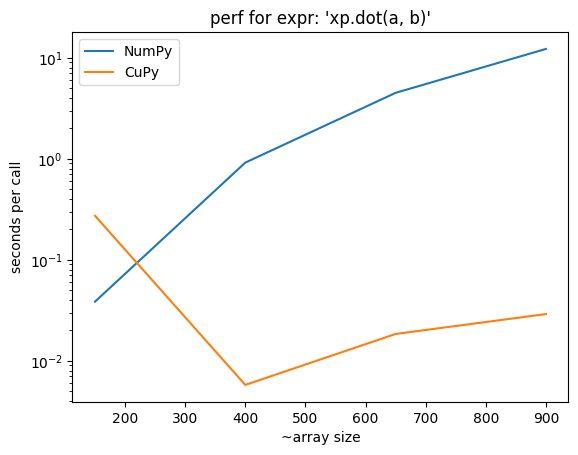

In [10]:
plot_perf_comp("xp.dot(a, b)")

.,.,.,.,done.


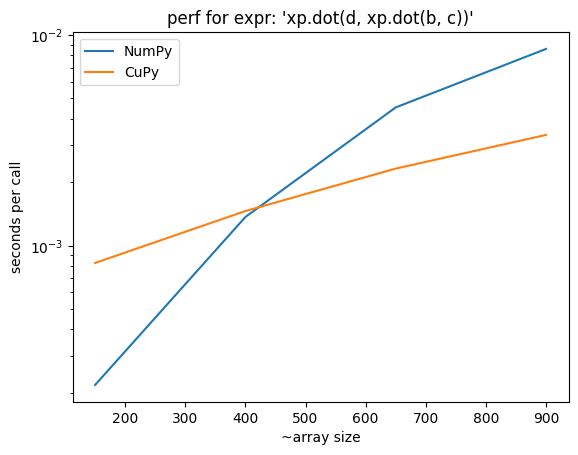

In [11]:
# plot_perf_comp("xp.dot(d, xp.dot(b, c))", 1000, 4000, 250, 100)
plot_perf_comp("xp.dot(d, xp.dot(b, c))")

.,.,.,.,done.


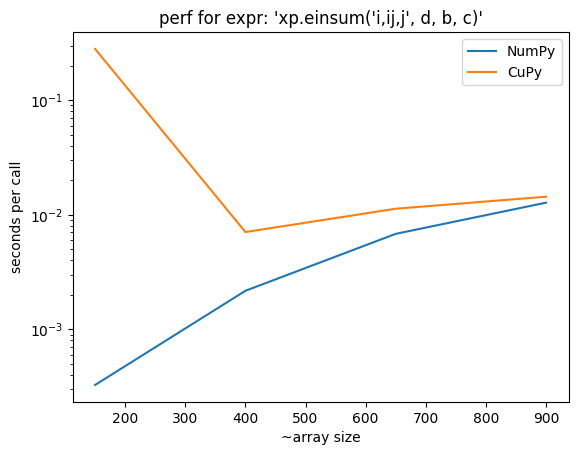

In [12]:
plot_perf_comp("xp.einsum('i,ij,j', d, b, c)")

.,.,.,.,done.


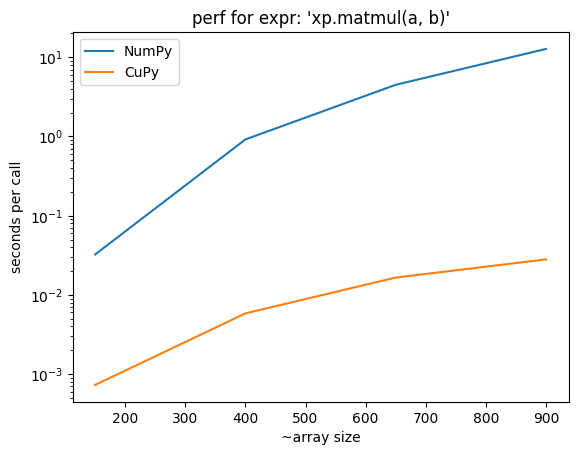

In [13]:
plot_perf_comp("xp.matmul(a, b)")

.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,done.


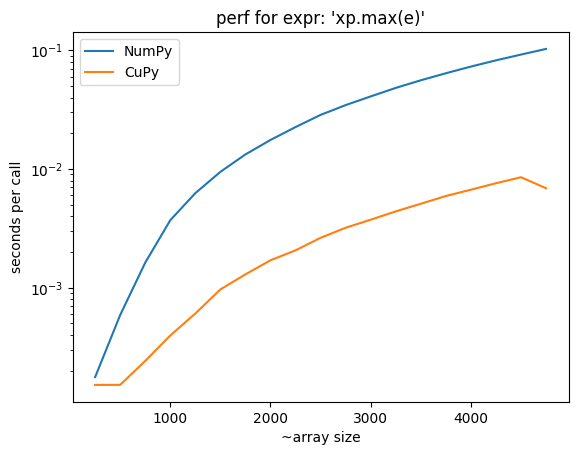

In [14]:
plot_perf_comp("xp.max(e)", 250, 5000, 250)

.,.,.,.,done.


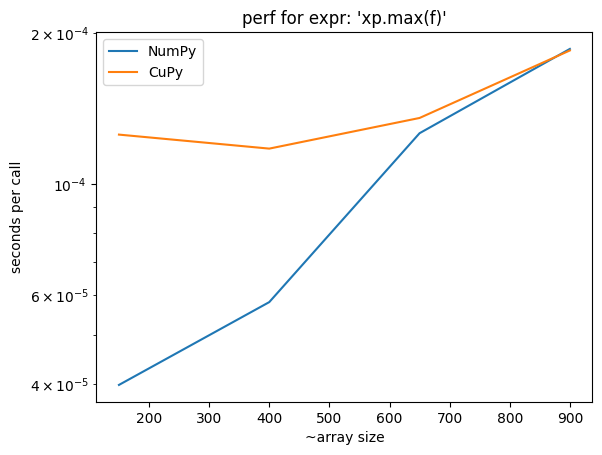

In [15]:
plot_perf_comp("xp.max(f)")